<a href="https://colab.research.google.com/github/JuanIgnaMurua/Grupo-6-ISPC-Proyecto-HotelExplora/blob/main/Hotel_Explora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hotel Explora: Transformando la Experiencia de Reservar con NLP y Deep Learning**

Bienvenidos a la presentación sobre cómo Hotel Explora va a transformar la experiencia de reservar con NLP y Deep Learning. Descubriremos cómo estas tecnologías revolucionarias están cambiando la industria hotelera.

In [1]:
!pip install wordcloud
!pip install tensorflow
!pip install requests

In [2]:
# PASO 1: Importar librerías y configuraciones iniciales
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
# PASO 2: Cargar los datos
data = pd.read_csv('/content/7282_1.csv', engine='python', on_bad_lines='skip')
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [4]:
# PASO 3: Preprocesar los datos
#Filtrar calificaciones que son 0
data = data[data['reviews.rating']>0]
#Cambia el nombre de los nombres de las columnas que tienen un '.' en ellos
data = data.rename(index=str, columns={'reviews.date':'reviewsdate', 'reviews.dateAdded':'reviewsdateAdded',
       'reviews.doRecommend':'reviewsdoRecommend', 'reviews.id':'reviewsid', 'reviews.rating':'reviewsrating', 'reviews.text':'reviewstext',
       'reviews.title':'reviewstitle', 'reviews.userCity':'reviewsuserCity', 'reviews.username':'reviewsusername',
       'reviews.userProvince':'reviewsuserProvince'})
data.reviewstext = data.reviewstext.fillna('x')

# Filtrado de valoraciones superior a 5
data = data[data['reviewsrating']<=5]
# Redondeo de valoraciones
data.reviewsrating = data.reviewsrating.astype(int)


In [5]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviewsdate,reviewsdateAdded,reviewsdoRecommend,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [5]:
#PASO 4: Funcion de Limpieza de reseñas.
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

In [6]:
# PASO 5: Mostrar Pais unico en los datos en este caso US
unique_countries = data['country'].unique()

# Devuelve el pais
print("Unico pais en el dataset:")
for country in unique_countries:
    print(country)

Unico pais en el dataset:
US


In [ ]:
# PASO 6: Visualizar la ubicación de las reseñas de hoteles
plt1 = go.Scatter(x = data.longitude, y=data.latitude, mode = 'markers')
lyt1 = go.Layout(title="Ubicaciones de reseñas de hoteles", xaxis=dict(title='Longitud'), yaxis=dict(title='Latitud'))
fig1 = go.Figure(data=[plt1], layout=lyt1)
iplot(fig1)

In [7]:
# PASO 7: Filtrar datos para incluir solo los puntos dentro de los EE.UU.
data = data[((data['latitude']<=50.0) & (data['latitude']>=24.0)) & ((data['longitude']<=-65.0) & (data['longitude']>=-122.0))]

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [11]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
# PASO 8: Crea un campo que muestre la longitud de cada reseña
tmp = list()
for i in range(len(data)):
    tmp.append(cleanme(data.iloc[i,:]['reviewstext']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

In [13]:
# PASO 9: Añadir columnas calculadas de nuevo al conjunto de datos
data = data.reset_index()
data = pd.concat([data,tmp], axis=1)
data

,index,address,categories,city,country,latitude,longitude,name,postalCode,province,...,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince,reviewlen,cleanrev,adjreview
0,60,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,"We had a wonderful, relaxing time. The staff w...",Hospitality at its Best!,Albany,Flo H,NY,36,"wonderful , relaxing time . staff completely a...",wonderful relaxing attentive deluxe available ...
1,61,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,We were in Palm Springs on the day the tempera...,Pure delight!,North Houston,Julie R,TX,37,palm springs day temperature 123 degrees ! des...,palm wonderful little paradise friendly little...
2,62,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,We arrived in Palm Springs not sure what to ex...,Awesome! Quiet secluded tranquility,North Houston,martin n,TX,42,arrived palm springs sure expect .... 's quiet...,sure quiet residential wooden sure spacious we...
3,63,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,This place really is a little paradise!! A bea...,As the title suggests....,Los Angeles,shetravels66,CA,44,place really little paradise ! ! beautiful bou...,little beautiful fresh best comfortable wonder...
4,64,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,Spent 3 nights at Little Paradise boutique hot...,Loved this Wonderful Boutique Hotel!,Los Angeles,Mary Ellen R,CA,45,spent 3 nights little paradise boutique hotel ...,little paradise mother-daughter wonderful rela...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29458,35905,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,We truly enjoyed staying at the Elk Springs re...,We Loved It!,Charlotte,randolphtiffany,NC,40,truly enjoyed staying elk springs resort ! qui...,elk quiet peaceful clean perfect helpful last ...
29459,35906,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,We were here for a 2nd time the last weekend o...,Amazing time (both times!!),Charlotte,Sabrina P,NC,36,2nd time last weekend april ( stayed deer hear...,last first first first second more
29460,35907,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,Best of the Best!!!! My family and I stayed in...,Amazing time (both times!!),Charlotte,Chelsa K.,NC,55,best best ! ! ! ! family stayed grin bear cabi...,best best best perfect gorgeous elk profession...
29461,35908,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,Amazing Vacation in Beautiful Cabin We stayed ...,Amazing time (both times!!),Charlotte,Heather D.,NC,33,amazing vacation beautiful cabin stayed long w...,beautiful long relaxing most nice most nice bu...


In [14]:
# PASO 10: Visualizar la frecuencia de la longitud de las reseñas
plt2 = go.Histogram(x = data.reviewlen)
lyt2 = go.Layout(title="Frecuencia de la longitud de las reseñas", xaxis=dict(title='longitud de las reseñas', range=[0,400]), yaxis=dict(title='Frequency'))
fig2 = go.Figure(data=[plt2], layout=lyt2)
iplot(fig2)

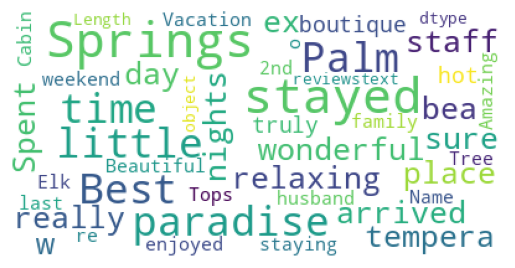

In [ ]:
# PASO 11: Crear y mostrar una nube de palabras
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200,
    max_font_size=40,
    random_state=42
).generate(str(data['reviewstext']))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# PASO 12: Visualizar la longitud de las reseñas frente a la calificación
data = data.sort_values(by='reviewlen')
plt3 = go.Scatter(x = data.reviewlen, y = data.reviewsrating, mode='markers')
lyt3 = go.Layout(title="Longitud de la reseña vs. Calificación por estrellas", xaxis=dict(title='Longitud de la reseña'),yaxis=dict(title='Rating'))
fig3 = go.Figure(data=[plt3], layout=lyt3)
iplot(fig3)
print("Correlación entre la longitud de la reseña y la calificación:",data.reviewlen.corr(data.reviewsrating))

Correlación entre la longitud de la reseña y la calificación: -0.1605662318320769


In [47]:
# PASO 13: Configurar los datos X e Y para los modelos de machine learning
#Configurar los datos X e Y, donde X es el texto de revisión e Y es la calificación
#Se utilizarán tres entradas diferentes: texto de revisión original, texto de revisión limpio y texto de revisión solo de adjetivos.
x1 = data.reviewstext
x2 = data.cleanrev
x3 = data.adjreview
y = data.reviewsrating

In [48]:
# PASO 14: Crear un vectorizador para dividir el texto en unigrams y bigrams
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect2 = vect.fit_transform(x2)
x_vect1 = vect.fit_transform(x1)
x_vect3 = vect.fit_transform(x3)

In [39]:
# PASO 15: Definir funciones para Linear SVC, KNN y Naive Bayes
def entrenar_linsvc(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = LinearSVC(dual=False)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("Linear SVC Accuracy:", accuracy)
    return classf, accuracy

def entrenar_knn(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("KNN Accuracy:", accuracy)
    return classf, accuracy

def entrenar_naive_bayes(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("Naive Bayes Accuracy:", accuracy)
    return classf, accuracy

In [40]:
# PASO 16: Entrenamiento y evaluacion de modelos
svm_model, svm_accuracy = entrenar_linsvc(x_vect2, y)
knn_model, knn_accuracy = entrenar_knn(x_vect2, y)
nb_model, nb_accuracy = entrenar_naive_bayes(x_vect2, y)

# Comparamos las precisiones
print("Linear SVC Accuracy:", svm_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)

Linear SVC Accuracy: 0.5065164268259571
KNN Accuracy: 0.14702688026065708
Naive Bayes Accuracy: 0.3995384197664947
Linear SVC Accuracy: 0.5065164268259571
KNN Accuracy: 0.14702688026065708
Naive Bayes Accuracy: 0.3995384197664947


In [ ]:
# PASO 17: Crear y mostrar una matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
  Esta función imprime y traza la matriz de confusión.
 La normalización se puede aplicar configurando `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]),decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.88 0.03 0.03 0.02 0.03]
 [0.06 0.77 0.08 0.05 0.03]
 [0.02 0.02 0.8  0.09 0.08]
 [0.01 0.01 0.03 0.82 0.13]
 [0.   0.   0.01 0.06 0.93]]
Normalized confusion matrix
[[0.77 0.   0.23 0.   0.  ]
 [0.01 0.75 0.24 0.   0.  ]
 [0.   0.01 0.98 0.   0.  ]
 [0.   0.01 0.91 0.07 0.01]
 [0.   0.   0.9  0.03 0.06]]
Normalized confusion matrix
[[0.16 0.   0.01 0.17 0.65]
 [0.   0.01 0.03 0.33 0.63]
 [0.   0.   0.13 0.21 0.65]
 [0.   0.   0.   0.45 0.55]
 [0.   0.   0.   0.01 0.99]]


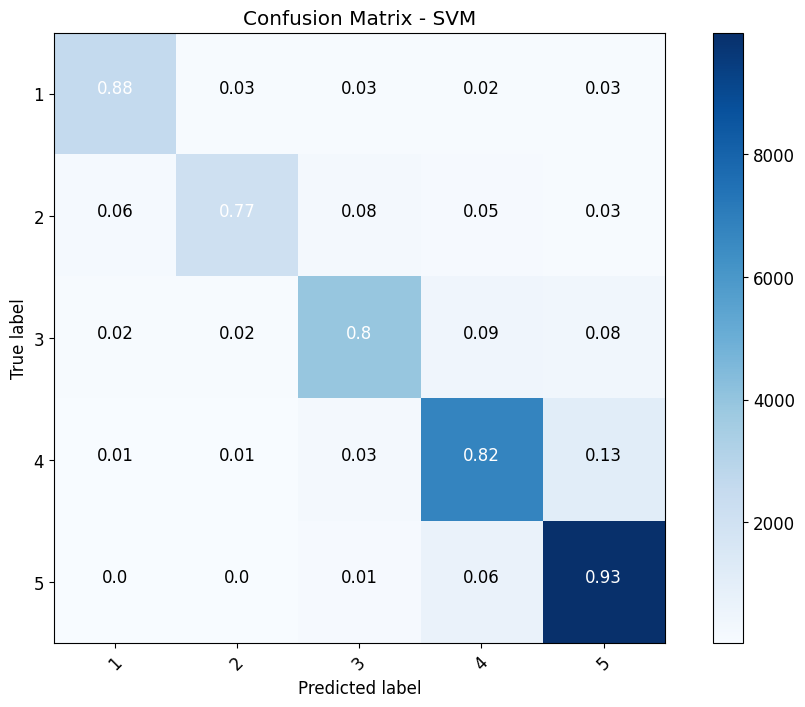

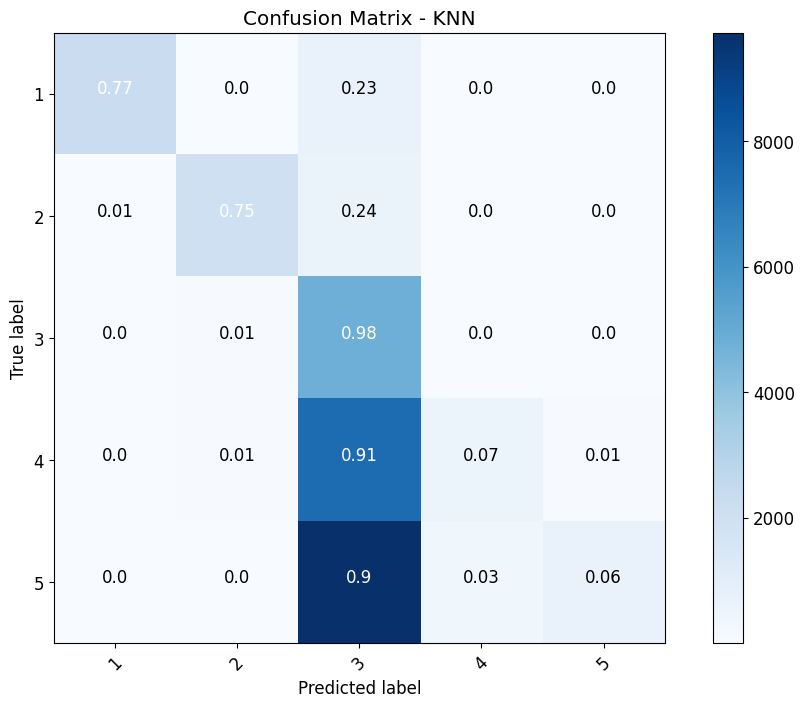

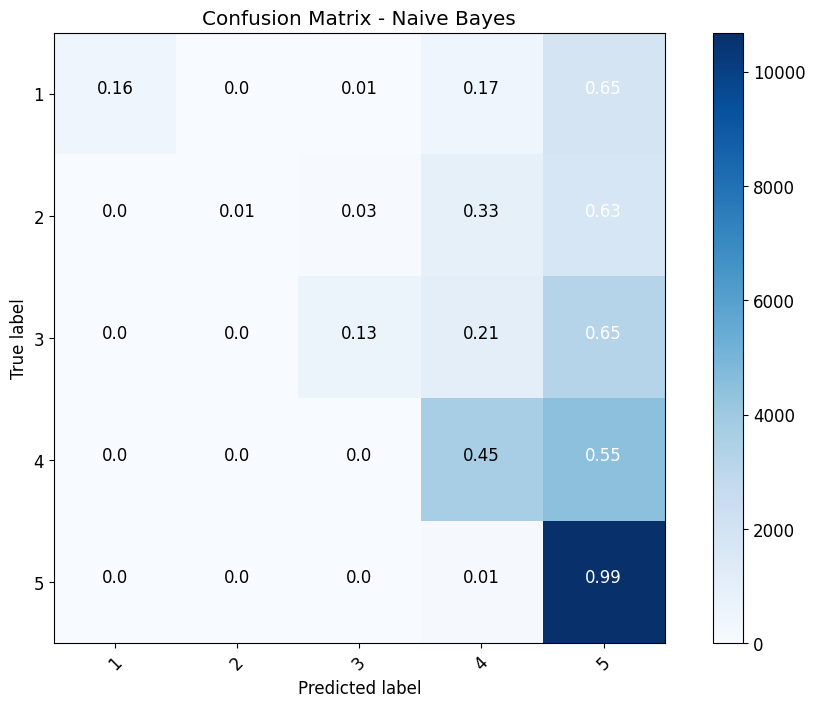

In [ ]:
# Matrices de confusión
c1 = confusion_matrix(y, svm_model.predict(x_vect2))
c2 = confusion_matrix(y, knn_model.predict(x_vect2))
c3 = confusion_matrix(y, nb_model.predict(x_vect2))

# Nombres de las clases
class_names = ['1', '2', '3', '4', '5']

# Graficar matrices de confusión
plt.figure(figsize=(10, 7))
plot_confusion_matrix(c1, classes=class_names, normalize=True, title='Confusion Matrix - SVM')

plt.figure(figsize=(10, 7))
plot_confusion_matrix(c2, classes=class_names, normalize=True, title='Confusion Matrix - KNN')

plt.figure(figsize=(10, 7))
plot_confusion_matrix(c3, classes=class_names, normalize=True, title='Confusion Matrix - Naive Bayes')

plt.show()

In [ ]:
print(data.columns)

Index(['index', 'address', 'categories', 'city', 'country', 'latitude',
       'longitude', 'name', 'postalCode', 'province', 'reviewsdate',
       'reviewsdateAdded', 'reviewsdoRecommend', 'reviewsid', 'reviewsrating',
       'reviewstext', 'reviewstitle', 'reviewsuserCity', 'reviewsusername',
       'reviewsuserProvince', 'reviewlen', 'cleanrev', 'adjreview'],
      dtype='object')


In [ ]:
city_list = data['city'].tolist()

In [ ]:
print(city_list)

['Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Glendale', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermo

##**Sistema de recomendación y de clasificación de hoteles por rating y ciudad utilizando NLP**##

Este código define una función hotel_recommendation que recomienda hoteles en una ciudad dada con una clasificación dentro de un rango específico. Filtra los datos según la ciudad, calcula el promedio de clasificación y sentimiento de las reseñas para cada hotel y devuelve las tres mejores recomendaciones, priorizando el sentimiento positivo y el promedio de calificaciones.

In [53]:
# Descargar recursos necesarios de NLTK
nltk.download('vader_lexicon')

# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

def hotel_recommendation(city, rating, data):
    if city.strip() == "" or not isinstance(rating, (int, float)):
        print("Error: Ingrese una ciudad válida y un rating numérico.")
        return pd.DataFrame()

    # Filtrar por ciudad
    city_data = data[data['city'].str.lower() == city.lower()]

    if city_data.empty:
        print(f"No se encontraron hoteles en la ciudad: {city}.")
        return pd.DataFrame()

    # Convertir la columna 'reviewsrating' a numérica y manejar valores faltantes
    city_data['reviewsrating'] = pd.to_numeric(city_data['reviewsrating'], errors='coerce')
    city_data = city_data.dropna(subset=['reviewsrating'])

    # Filtrar hoteles por rango de rating
    min_rating, max_rating = max(0, rating - 1), min(5, rating + 1)
    filtered_hotels = city_data[
        (city_data['reviewsrating'] >= min_rating) &
        (city_data['reviewsrating'] <= max_rating)
    ]

    if filtered_hotels.empty:
        print(f"No se encontraron hoteles con ratings entre {min_rating} y {max_rating} en {city}.")
        return pd.DataFrame()

    # Analiza los sentimientos de las reseñas y agregar columna de sentimiento promedio
    city_data['sentiment'] = city_data['reviewstext'].apply(
        lambda x: sia.polarity_scores(str(x))['compound']
    )
    # Calcula promedio de ratings y sentimientos por hotel
    avg_metrics_per_hotel = city_data.groupby(['name', 'address']).agg({
        'reviewsrating': 'mean',
        'sentiment': 'mean'
    }).reset_index().rename(columns={
        'reviewsrating': 'average_rating',
        'sentiment': 'average_sentiment'
    })

    # Filtrar hoteles por rango de rating solicitado
    min_rating, max_rating = max(0, rating - 1), min(5, rating + 1)
    filtered_recommendations = avg_metrics_per_hotel[
        (avg_metrics_per_hotel['average_rating'] >= min_rating) &
        (avg_metrics_per_hotel['average_rating'] <= max_rating)
    ]

    if filtered_recommendations.empty:
        print(f"No se encontraron hoteles con ratings entre {min_rating} y {max_rating} en {city}.")
        return pd.DataFrame()

    # Ordenar por sentimiento promedio y luego por rating promedio
    recommendations = filtered_recommendations.sort_values(
        by=['average_sentiment', 'average_rating'], ascending=False
    ).head(3)

    return recommendations

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [56]:
# Ejemplo de uso:
city = 'Houston'
rating = 4
# Asegúrate de que 'data' tenga columnas: 'city', 'reviewsrating', 'reviews', 'name', y 'address'
recommendations = hotel_recommendation(city, rating, data)
print(recommendations)

                      name                       address  average_rating  \
2  Hilton Americas-houston                    1600 Lamar        4.133333   
5     The Houstonian Hotel             111 N Post Oak Ln        4.640625   
0           Comfort Suites  1055 E Mcnee Road Of Main St        3.666667   

   average_sentiment  
2           0.886580  
5           0.704934  
0           0.533900  


<ipython-input-53-98744365ab11>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
# Ejemplo de uso 2:
city ='Palm Springs'
rating = 4
recommendations = hotel_recommendation(city, rating, data)
print(recommendations)

                    name                address  average_rating  \
1  Little Paradise Hotel  435 E Avenida Olancha            4.85   
0          Helios Resort          280 E Mel Ave            3.00   

   average_sentiment  
1            0.83749  
0            0.77830  


<ipython-input-53-98744365ab11>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# **Sistema de Recomendación de Hoteles por Ciudad y Calificación utilizando SVM y TF-IDF**

Este sistema tiene como objetivo recomendar hoteles en una ciudad específica basándose en las calificaciones promedio otorgadas por los usuarios y en el análisis de los comentarios escritos. Utiliza un modelo de Máquina de Soporte Vectorial (SVM) previamente entrenado para analizar los sentimientos expresados en los comentarios, y un vectorizador TF-IDF para convertirlos en un formato numérico.

La combinación de calificaciones y sentimientos permite generar recomendaciones más completas y relevantes para los usuarios, priorizando hoteles que no solo tienen buenas calificaciones numéricas, sino también reseñas positivas.

In [51]:
def recommend_hotels(city, rating_range, model, vectorizer, data, all_review_vectors):
    # Filtro de datos por ciudad
    filtered_data = data[data['city'].str.lower() == city.lower()]

    if filtered_data.empty:
        print("No se encontraron hoteles en la ciudad especificada.")
        return

    # Calcular el promedio de calificaciones para cada hotel en la ciudad filtrada:
    avg_ratings = filtered_data.groupby('name')['reviewsrating'].mean()

    # Rangos de calificación:
    rating_ranges = {
        1: (0.5, 1.4),
        2: (1.5, 2.4),
        3: (2.5, 3.4),
        4: (3.5, 4.4),
        5: (4.5, 5)
    }

    # Filtrar hoteles por el rango de calificación deseado dentro de la ciudad filtrada:
    min_rating, max_rating = rating_ranges[rating_range]
    filtered_hotels = avg_ratings[(avg_ratings >= min_rating) & (avg_ratings <= max_rating)]

    if filtered_hotels.empty:
        print("No se encontraron hoteles con el rating deseado en la ciudad especificada.")
        return

    # Utilizar la matriz TF-IDF original (all_review_vectors):
    review_vectors = all_review_vectors[data['name'].isin(filtered_hotels.index)]

    # Predecir el sentimiento utilizando la matriz TF-IDF CORRECTA:
    predicted_sentiments = model.predict(review_vectors)

    # Agregar las predicciones de sentimiento a los datos filtrados:
    filtered_data.loc[filtered_data['name'].isin(filtered_hotels.index), 'sentiment'] = predicted_sentiments

    # Calcular el promedio de sentimiento para cada hotel filtrado:
    sentiment_scores = filtered_data.groupby('name')['sentiment'].mean()

    # Combinar calificaciones y sentimientos para generar recomendaciones:
    recommendations = pd.DataFrame({
        'average_rating': avg_ratings,
        'average_sentiment': sentiment_scores
    }).dropna()

    # Filtrar recomendaciones por rango de calificación y ordenar por sentimiento:
    recommendations = recommendations[
        (recommendations['average_rating'] >= min_rating) &
        (recommendations['average_rating'] <= max_rating)
    ].sort_values(by='average_sentiment', ascending=False)

    # Mostrar las recomendaciones:
    if recommendations.empty:
        print("No se encontraron hoteles que cumplan los criterios.")
    else:
        print(f"Hoteles recomendados en {city} con calificación entre {min_rating} y {max_rating}:\n")
        for hotel_name in recommendations.index:
            hotel_data = filtered_data[filtered_data['name'] == hotel_name].iloc[0]
            print("Nombre del hotel: ", hotel_name)
            print("Promedio de calificación: ", recommendations.loc[hotel_name, 'average_rating'])
            print("Promedio de sentimiento: ", recommendations.loc[hotel_name, 'average_sentiment'])
            print("Dirección: ", hotel_data['address'])
            print("Comentario de muestra: ", hotel_data['reviewstext'])
            print("\n")

In [52]:
recommend_hotels("Columbia", 3, svm_model, vect, data, x_vect2)

Hoteles recomendados en Columbia con calificación entre 2.5 y 3.4:

Nombre del hotel:  Howard Johnson Inn Columbia
Promedio de calificación:  3.3209876543209877
Promedio de sentimiento:  3.382716049382716
Dirección:  3100 I 70 Doctor S E
Comentario de muestra:  Stay here alot, kids go to school in Columbia and this hotel has become my home away from home.




<ipython-input-51-72df5046fc73>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#**Modelo de clasificación de imágenes de hoteles mediante transferencia de aprendizaje con ResNet50 y Deep Learning**#


Objetivo: Desarrollar un modelo de clasificación de imágenes de hoteles utilizando transferencia de aprendizaje con ResNet50, optimizado para precisión y eficiencia. Este modelo empleará técnicas avanzadas de Deep Learning para diferenciar habitaciones de hotel y exterior de hotel, mejorando así la automatización en la clasificación visual de alojamientos y facilitando la gestión de imágenes en aplicaciones turísticas y hoteleras.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 201 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - accuracy: 0.8943 - loss: 0.3878 - val_accuracy: 0.9184 - val_loss: 0.3189
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.9481 - loss: 0.2586 - val_accuracy: 0.9184 - val_loss: 0.5893
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.9039 - loss: 0.6878


Precisión del modelo: 91.84%
Len acc: 3
Len val_acc: 2
Len loss: 3
Len val_loss: 2


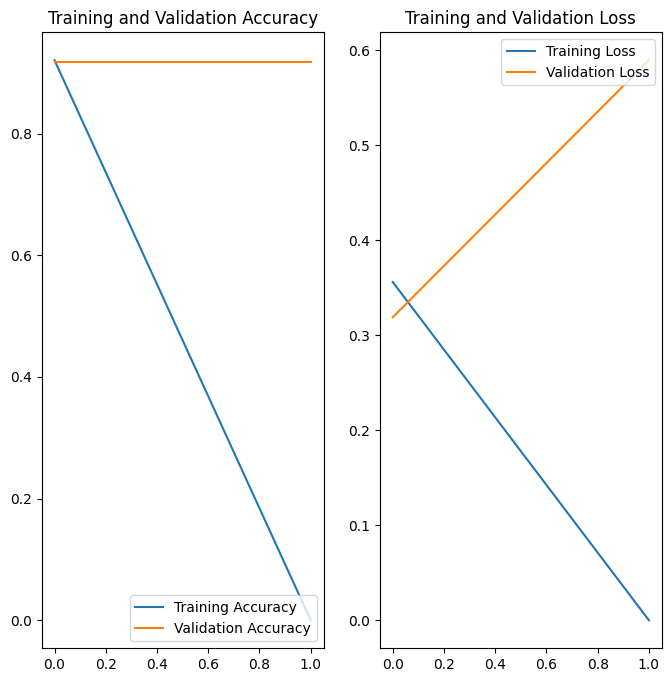

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


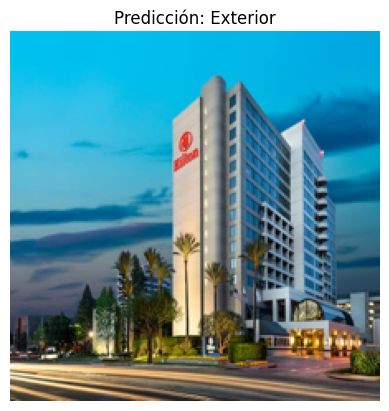

In [ ]:
#Importa las bibliotecas necesarias. Se utilizan TensorFlow y Keras para construir y entrenar el modelo,
#así como otras bibliotecas auxiliares para la manipulación de imágenes y gráficos.
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import requests
from PIL import Image
from io import BytesIO
from google.colab import drive

def train_and_evaluate_model():
    #Monta Google Drive para acceder a los datos y guardar el modelo entrenado.
    drive.mount('/content/drive')

    # Paso 2: Cargar y preprocesar los datos
    #Esta función entrena un modelo de clasificación de imágenes usando ResNet50 y evalúa su rendimiento.
    data_dir = '/content/drive/MyDrive/dataset'
    img_height, img_width = 224, 224
    batch_size = 32

    # Generador de datos para entrenamiento y validación
    # el 20% de los datos se utilizan para la validación (test) y el 80% restante se utiliza para el entrenamiento.
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    # Paso 3: Construir y entrenar el modelo con ResNet50
    #Crea el modelo base usando ResNet50 preentrenado (sin la capa superior). Luego, construye un modelo secuencial que añade una capa de pooling global,
    # una capa densa de 512 neuronas y una capa de salida con una activación softmax para la clasificación.
    #Compila el modelo con el optimizador Adam y la pérdida de entropía cruzada categórica. Luego, se entrena el modelo por 3 épocas y se guarda el historial de entrenamiento.
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    epochs = 3
    steps_per_epoch = (train_generator.samples + batch_size - 1) // batch_size
    validation_steps = (validation_generator.samples + batch_size - 1) // batch_size

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps
    )

    # Paso 4: Evaluar el modelo
    #Evalúa el modelo en el conjunto de validación y muestra la precisión obtenida.
    loss, accuracy = model.evaluate(validation_generator)
    print(f'Precisión del modelo: {accuracy * 100:.2f}%')

    #Guarda el modelo entrenado en Google Drive.
    model.save('/content/drive/My Drive/hotel_room_classifier_resnet50.h5')

    # Graficar los resultados de entrenamiento
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    print("Len acc:", len(acc))
    print("Len val_acc:", len(val_acc))
    print("Len loss:", len(loss))
    print("Len val_loss:", len(val_loss))

    # Ajustar epochs_range según la métrica más corta
    epochs_range = range(min(len(acc), len(val_acc)))

    # Grafica resultados
    plt.figure(figsize=(8, 8))

    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc[:len(epochs_range)], label='Training Accuracy')
    plt.plot(epochs_range, val_acc[:len(epochs_range)], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss[:len(epochs_range)], label='Training Loss')
    plt.plot(epochs_range, val_loss[:len(epochs_range)], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

    # Devolver el modelo y las etiquetas de clase
    # Genera gráficos de precisión y pérdida para los conjuntos de entrenamiento y validación
    # Devuelve el modelo entrenado y los índices de clase.
    return model, train_generator.class_indices

def load_image_from_url(url, target_size):
  try:
        response = requests.get(url, timeout=10, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img = img.resize(target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img, img_array
  except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {url}: {e}")
        return None, None

def predict_image_from_url(url, model, class_indices):
    # Cargar y preprocesar la imagen desde la URL
    img, img_array = load_image_from_url(url, target_size=(224, 224))

    # Realiza la predicción
    prediction = model.predict(img_array)

    # Muestra la imagen y la predicción
    plt.imshow(img)
    plt.axis('off')
    predicted_class = np.argmax(prediction[0])
    class_labels = {v: k for k, v in class_indices.items()}  # Reemplaza índices con etiquetas
    predicted_label = class_labels[predicted_class]
    plt.title(f'Predicción: {predicted_label}')
    plt.show()

# Función para entrenar y evaluar el modelo
model, class_indices = train_and_evaluate_model()

# URL de la imagen que vamos a predecir
image_url = 'https://www.hilton.com/im/en/BURWCHF/4581696/hiltonwhexteriormed-1.jpg?impolicy=crop&cw=3775&ch=2517&gravity=NorthWest&xposition=112&yposition=0&rw=640&rh=427'
predict_image_from_url(image_url, model, class_indices)